In [1]:
import os 
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import numpy as np
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM # type: ignore
from tensorflow.keras.layers import Dense, Dropout, TimeDistributed # type: ignore
from keras.layers import Input, LSTM, Dense
from keras.models import Model
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests


In [148]:
prices_df = pd.read_csv('prices/BTC-USD.csv')
trends_df = pd.read_csv('trends/bitcoin.csv')
tweets = pd.read_csv('bitcoin-tweets-2021.csv/bitcoin-tweets-2021.csv', nrows=10000000)

tweets.drop(columns=['text', 'username'], inplace=True)



C:\Users\victo\AppData\Local\Temp\ipykernel_6904\4197522790.py:3: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets = pd.read_csv('bitcoin-tweets-2021.csv/bitcoin-tweets-2021.csv', nrows=10000000)


In [149]:
import pandas as pd

# Assuming 'tweets' is your DataFrame with a column 'datetime'
# Convert 'datetime' column to datetime format, errors='coerce' will convert invalid values to NaT (Not a Time)
tweets['datetime'] = pd.to_datetime(tweets['datetime'], errors='coerce')

# Drop rows with NaT values (i.e., rows with values that couldn't be converted to datetime format)
tweets.dropna(subset=['datetime'], inplace=True)

# Now 'tweets' DataFrame only contains rows with valid datetime values in the 'datetime' column


In [150]:
# Assuming 'tweets' DataFrame has a column 'datetime' of type pandas._libs.tslibs.timestamps.Timestamp

# Extract the date portion from the 'datetime' column
tweets['date'] = tweets['datetime'].dt.date

# Count the occurrences of each unique date
daily_counts = tweets['date'].value_counts()

# If you want to sort the results by date:
daily_counts_sorted = daily_counts.sort_index()

# If you want to reset the index and rename the columns:
daily_counts_sorted = daily_counts_sorted.reset_index()
daily_counts_sorted.columns = ['date', 'count']

# Now, daily_counts_sorted DataFrame contains two columns: 'date' and 'count', showing the count of tweets for each day


In [151]:
# Remove the 'datetime' column
tweets.drop(columns=['datetime'], inplace=True)

# Count the occurrences of each unique date and store it in a new 'count' column
tweets['count'] = tweets.groupby('date')['date'].transform('count')

# Drop duplicate rows to keep only unique dates and their corresponding counts
tweets.drop_duplicates(subset=['date', 'count'], inplace=True)

# Now, 'tweets' DataFrame contains only the 'date' column and the 'count' column,
# where 'count' represents the number of times each date appears in the 'date' column



In [193]:
tweets.reset_index(drop=True, inplace=True)
tweets

,date,count
0,2021-01-01,26338
1,2021-01-02,64658
2,2021-01-03,57903
3,2021-01-04,44622
4,2021-01-05,38343
...,...,...
149,2021-05-30,37180
150,2021-05-31,37435
151,2021-06-01,38871
152,2021-06-02,69684


In [195]:
start_date = tweets['date'].iloc[0]
finish_date = tweets['date'].iloc[-1]
prices_df['Date'] = pd.to_datetime(prices_df['Date']).dt.date

filtered_prices_df = prices_df[prices_df['Date'] >= start_date]
filtered_prices_df = filtered_prices_df[filtered_prices_df['Date'] <= finish_date]


In [196]:
merged_df = filtered_prices_df.merge(tweets[['date', 'count']], left_on='Date', right_on='date', how='left')
merged_df.drop(columns=['date'], inplace=True)
merged_df.rename(columns={'count': 'Tweets'}, inplace=True)


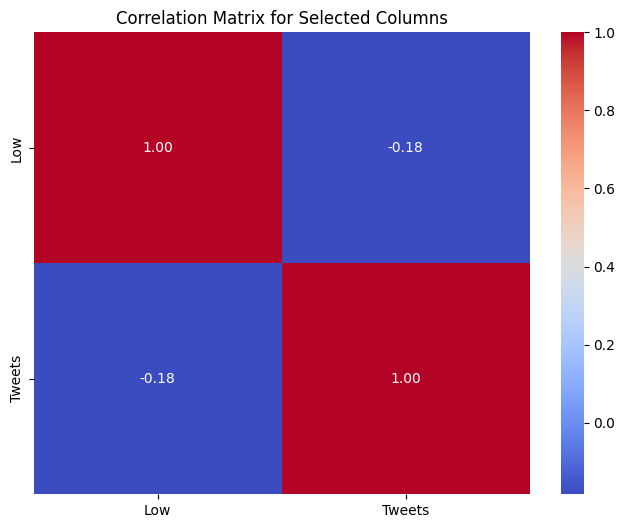

In [247]:
columns = ['Low', 'Tweets']
correlation_matrix_selected = merged_df[columns].corr()
# Plot correlation matrix heatmap for selected columns
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_selected, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Selected Columns')
plt.show()


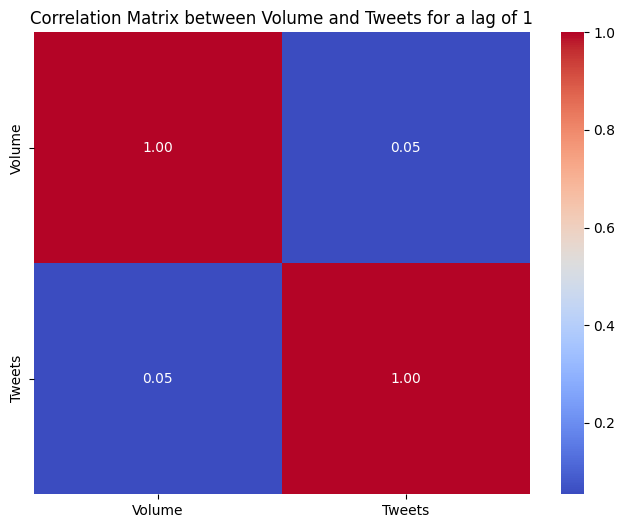

In [243]:
# Define the lag value
lag = 1  # Example lag value of 1 period

# Shift the columns by the lag value to create lagged values
lagged_df = merged_df[columns].shift(periods=lag)

# Perform correlation matrix on lagged values
correlation_matrix_lagged = lagged_df.corr()

# Display the correlation matrix for lagged values
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_lagged, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f"Correlation Matrix between {columns[0]} and {columns[1]} for a lag of {lag}")
plt.show()


In [233]:
import heapq

column1 = 'High'  # Replace with the name of the first column
column2 = 'Tweets'  # Replace with the name of the second column

# Initialize a heap to keep track of the top 5 maximum correlations
top_correlations = []

# Iterate over lag values from 1 to 100
for lag in range(1, 150):
    # Shift the columns by the lag value to create lagged values
    lagged_df = merged_df[[column1, column2]].shift(periods=lag)
    
    # Perform correlation matrix on lagged values
    correlation_matrix_lagged = lagged_df.corr()
    
    # Get the correlation coefficient between the two columns
    correlation_value = correlation_matrix_lagged.loc[column1, column2]
    
    # Update the top_correlations heap with the current correlation value and lag
    heapq.heappush(top_correlations, (correlation_value, lag))
    
    # If the heap size exceeds 5, remove the smallest element
    if len(top_correlations) > 5:
        heapq.heappop(top_correlations)

# Retrieve the top 5 maximum correlations and their corresponding lags
top_correlations = sorted(top_correlations, reverse=True)
print("Top 5 maximum correlations:")
for i, (corr, lag) in enumerate(top_correlations):
    print(f"{i+1}. Correlation: {corr}, Lag: {lag}")


Top 5 maximum correlations:
1. Correlation: 0.6404541910481736, Lag: 147
2. Correlation: 0.6225162520539702, Lag: 149
3. Correlation: 0.6168887410655662, Lag: 146
4. Correlation: 0.4980762080847699, Lag: 148
5. Correlation: 0.46648751628721946, Lag: 145


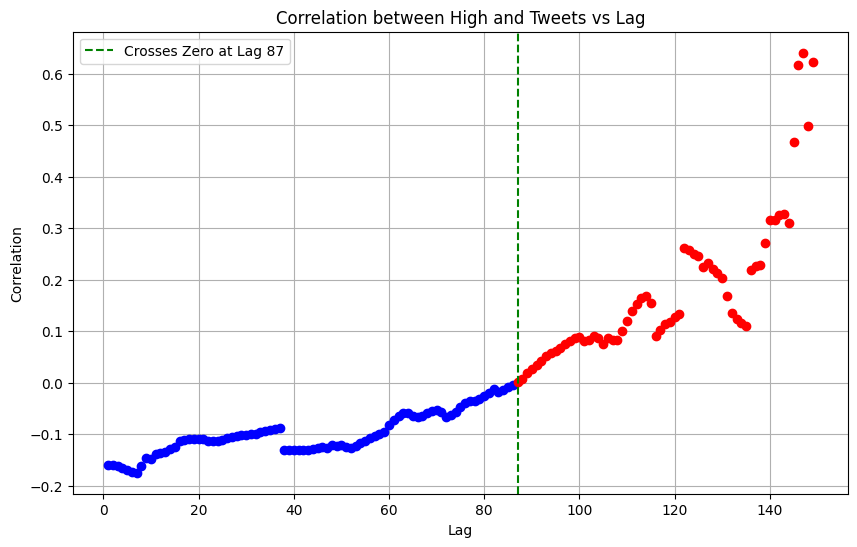

In [253]:
import matplotlib.pyplot as plt

column1 = 'High'  # Replace with the name of the first column
column2 = 'Tweets'  # Replace with the name of the second column

# Initialize lists to store lag values and corresponding correlation coefficients
lags = []
correlations = []

# Iterate over lag values from 1 to 100
for lag in range(1, 150):
    # Shift the columns by the lag value to create lagged values
    lagged_df = merged_df[[column1, column2]].shift(periods=lag)
    
    # Perform correlation matrix on lagged values
    correlation_matrix_lagged = lagged_df.corr()
    
    # Get the correlation coefficient between the two columns
    correlation_value = correlation_matrix_lagged.loc[column1, column2]
    
    # Append lag and correlation coefficient to lists
    lags.append(lag)
    correlations.append(correlation_value)

# Plot lag vs correlation
plt.figure(figsize=(10, 6))
for lag, corr in zip(lags, correlations):
    color = 'red' if corr > 0 else 'blue'
    plt.plot(lag, corr, marker='o', color=color)

plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title(f"Correlation between {column1} and {column2} vs Lag")
plt.grid(True)

# Find the index where the correlation crosses the 0 axis
index_cross_zero = next((i for i, corr in enumerate(correlations) if corr > 0 and correlations[i-1] <= 0), None)
if index_cross_zero is not None:
    lag_cross_zero = lags[index_cross_zero]
    plt.axvline(x=lag_cross_zero, color='green', linestyle='--', label=f'Crosses Zero at Lag {lag_cross_zero}')

plt.legend()
plt.show()


In [239]:
merged_df

,Date,Open,High,Low,Close,Adj Close,Volume,Trends,Tweets
0,2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359,0,26338
1,2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765,0,64658
2,2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202,0,57903
3,2021-01-04,32810.949219,33440.218750,28722.755859,31971.914063,31971.914063,81163475344,0,44622
4,2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782,0,38343
...,...,...,...,...,...,...,...,...,...
149,2021-05-30,34607.406250,36400.667969,33520.738281,35678.128906,35678.128906,31646080921,0,37180
150,2021-05-31,35658.593750,37468.250000,34241.945313,37332.855469,37332.855469,39009847639,0,37435
151,2021-06-01,37293.792969,37896.734375,35787.085938,36684.925781,36684.925781,34639423297,0,38871
152,2021-06-02,36699.921875,38231.339844,35966.308594,37575.179688,37575.179688,33070867190,0,69684


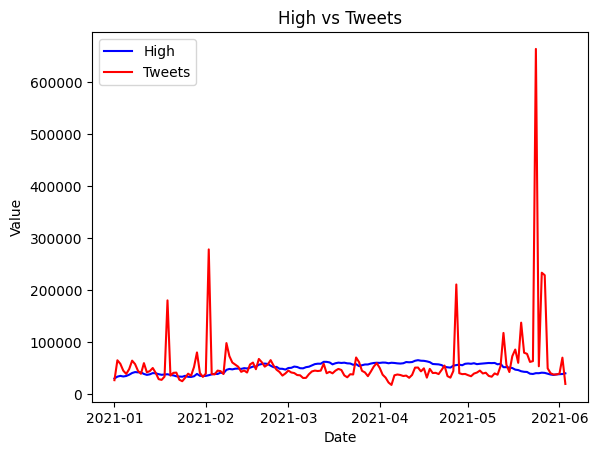

In [252]:
import matplotlib.pyplot as plt

# Plot merged_df['Date'] on the x-axis and merged_df['High'] on the y-axis in blue
plt.plot(merged_df['Date'], merged_df['High'], color='blue', label='High')

# Plot merged_df['Date'] on the x-axis and merged_df['Tweets'] on the y-axis in red
plt.plot(merged_df['Date'], merged_df['Tweets'], color='red', label='Tweets')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('High vs Tweets')
plt.legend()

# Show the plot
plt.show()
